# Data Generation

In [18]:
import bilby

import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor

import csv
import os

## Waveform Generation

In [19]:
waveform_duration = 5 # Seconds
sampling_frequency = 2048 # Hz
waveform_approximant = 'IMRPhenomA'
waveform_reference_frequency = 25 # Hz
waveform_minimum_frequency = 10 # Hz
waveform_pn_phase_order = -1 

In [20]:
waveform_generator = bilby.gw.WaveformGenerator(
            duration=waveform_duration, 
            sampling_frequency=sampling_frequency,
            frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole, # specify you're speaking the lal BBH language
            parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, # useful if you want to convert parameters under the hood
            waveform_arguments={
                "waveform_approximant": waveform_approximant,
                "reference_frequency": waveform_reference_frequency,
                "minimum_frequency": waveform_minimum_frequency,
                "pn_phase_order": waveform_pn_phase_order,
            },
        )

13:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [21]:
mass_ratio = 1

mass_1 = 30
mass_2 = mass_1*mass_ratio

In [22]:
injection_parameters = {
    'mass_1_source' : mass_1, #msol, in source frame
    'mass_2_source' : mass_2, #msol, in source frame
    'a_1' : 0,
    'a_2' : 0,
    'phi_jl' : 0,
    'phi_12' : 0,
    'tilt_1' : 0,
    'tilt_2' : 0,
    'luminosity_distance' : 5000, #in Mpc
    'dec' : 0.,
    'ra' : 0.,
    'theta_jn' : 0.,
    'psi' : 0.,
    'phase' : 0.,
    'geocent_time' : 0,
}


In [23]:
waveform_frequencies = waveform_generator.frequency_array
polarizations = waveform_generator.frequency_domain_strain(injection_parameters)

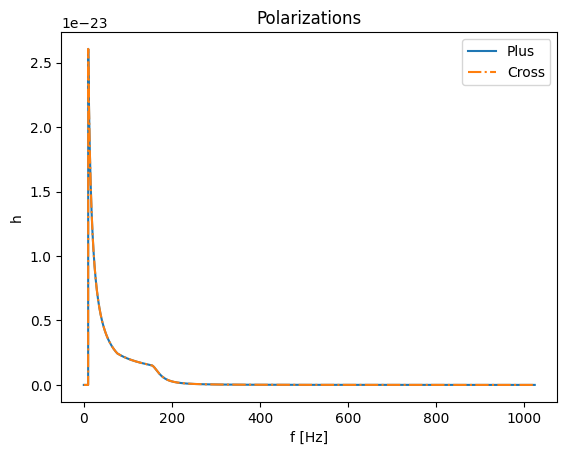

In [24]:
plt.title("Polarizations")
plt.plot(waveform_frequencies, np.abs(polarizations['plus']), label="Plus")
plt.plot(waveform_frequencies, np.abs(polarizations['cross']), linestyle='-.', label="Cross")
plt.xlabel("f [Hz]")
plt.ylabel("h")
plt.legend()
plt.show()

## Preparing the data

In [54]:
X = waveform_frequencies
y = np.abs(polarizations['plus'])

(5121,)

In [26]:
rescaled_y = (y-np.mean(y))/np.std(y)

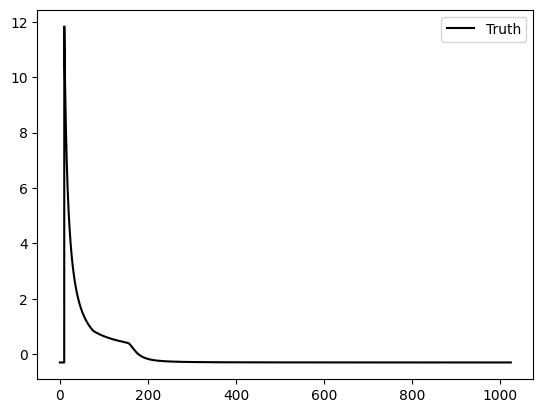

In [27]:
plt.plot(X,rescaled_y,label="Truth",c="black")
plt.legend()
plt.show()

### Creating Data evenly spaced in the logarithmic space

In [28]:
# Zero problem in X
idx_X = (X==0)
eps_X = np.min(X[~idx_X])*1e-5
X[idx_X] = eps_X

In [31]:
Xfinal = np.logspace(np.log(np.min(X)),np.log(np.max(X)),num=10000,base=np.e).reshape(-1, 1)

In [32]:
gp = GaussianProcessRegressor()

gp.fit(X.reshape(-1, 1),rescaled_y)

y_pred = gp.predict(Xfinal)

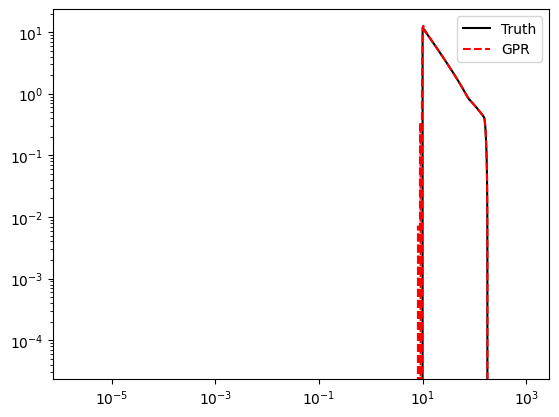

In [45]:
plt.plot(X,rescaled_y,label="Truth",c="black")
plt.plot(Xfinal,y_pred,linestyle='--',label="GPR",c="red")
plt.legend()
plt.loglog()
plt.show()

In [67]:
# Zero problem in y_pred
idx_y_pred = (y_pred<=0) #Check
eps_y_pred = np.min(y_pred[~idx_y_pred])*1e-5
y_pred[idx_y_pred] = eps_y_pred

# Zero problem in y
idx_rescaled_y = (rescaled_y<=0) #Check
eps_rescaled_y = np.min(rescaled_y[~idx_rescaled_y])*1e-5
rescaled_y[idx_rescaled_y] = eps_rescaled_y

In [72]:
# Correction by hand
y_pred[(np.squeeze(Xfinal)<waveform_minimum_frequency)] = y_pred[0]

In [77]:
Xtrain = np.log(np.squeeze(Xfinal))
ytrain = np.log(y_pred)

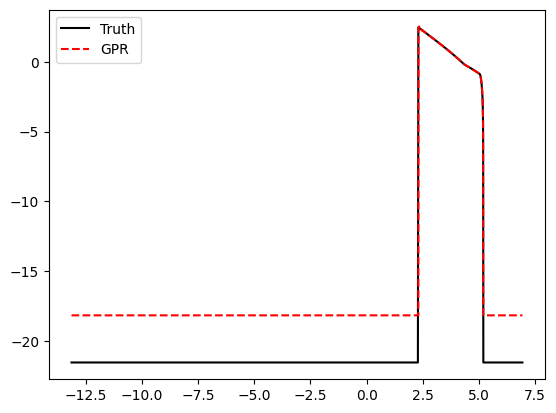

In [78]:
plt.plot(np.log(X),np.log(rescaled_y),label="Truth",c="black")
plt.plot(Xtrain,ytrain,linestyle='--',label="GPR",c="red")
plt.legend()
plt.show()

## Creating a Data File

In [79]:
# Zip the arrays together
rows = zip(Xtrain, ytrain, mass_ratio*np.ones(len(Xtrain)))

# Specify the CSV file path
csv_file_path = 'freq_data.csv'

# Function to clean the file before writing
def clean_file(file_path):
    if os.path.exists(file_path):
        os.remove(file_path)

# Write to CSV
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    # Write header if needed
    csv_writer.writerow(['X', 'y', 'q'])
    
    # Write data rows
    csv_writer.writerows(rows)

print(f"CSV file '{csv_file_path}' has been generated.")

CSV file 'freq_data.csv' has been generated.
